In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
import scipy.sparse.linalg as spla

np.set_printoptions(linewidth=130)

In [2]:
from fsmpfuncs import *
from gridfuncs import *

Numerical grid for the fluid

In [3]:
stretchingFactor=2

s = stretching(16, 1, stretchingFactor, 10, 16, 16, 0.04)[0]
s = np.concatenate([s[:-1], s[-1]-(s[::-1]-s[-1])])
s/=s[-1]

x = s.copy()

s = stretching(16, 1, stretchingFactor, 10, 16, 16, 0.04)[0]
s = np.concatenate([s[:-1], s[-1]-(s[::-1]-s[-1])])
s/=s[-1]
y = s.copy()

n, m = len(y)-1, len(x)-1

dy, dx = np.diff(y), np.diff(x)
dxmin = min(np.min(dx), np.min(dy))

yp, xp = 0.5*(y[1:] + y[:-1]), 0.5*(x[1:] + x[:-1])
dyp, dxp = np.diff(yp), np.diff(xp)
p = np.zeros( (n, m) )

yu, xu = yp, x[1:-1]
u = np.zeros( (n, m-1) )

yv, xv = y[:-1], xp
v = np.zeros( (n, m) )

Plot grid and immersed boundary

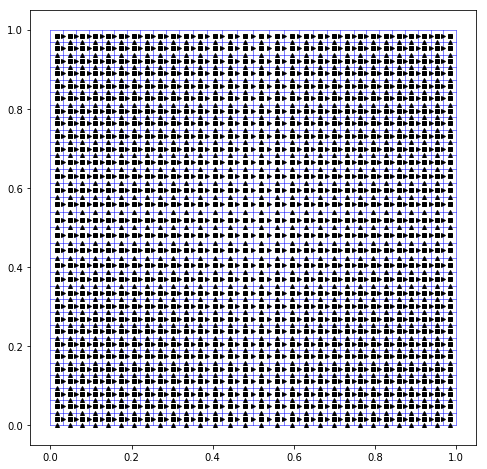

In [4]:
plt.figure(figsize=(8,8))
X, Y = np.meshgrid(x, y)
plt.plot(X, Y, 'b-', lw=0.5);
plt.plot(X.T, Y.T, 'b-', lw=0.5);
plt.plot(*np.meshgrid(xu,yu), 'k>', ms=4);
plt.plot(*np.meshgrid(xv,yv), 'k^', ms=4);
plt.plot(*np.meshgrid(xp,yp), 'ks', ms=4);

In [6]:
uE, uW = np.zeros(n), np.zeros(n)
vE, vW = np.zeros(n), np.ones(n)

u[:,:]=0
v[:,:]=0

Build matrices (I)

In [7]:
G, DuW, DuE = gradient(dxp, dyp)
R, iR = weight (dx, dy)
Mh, iMh = mass_hat (dx, dy, dxp, dyp)
Lh, Lux0, Lux1, Lvx0, Lvx1 = laplacian_hat(dx, dy, dxp, dyp)
L = Mh.dot(Lh.dot(iR))

M = Mh.dot(iR)
iM = R.dot(iMh)

iML = iM.dot(L)
Q = G

Build matrices (II)

In [8]:
iRe = 1/1.0
dt = 0.9 * min(dxmin**2/iRe, dxmin)
print(dxmin**2/iRe, dxmin)

0.000996609086634 0.0315691160255


In [9]:
A = (M/dt - 0.5*iRe*L).tocsc()
B = (M/dt + 0.5*iRe*L).tocsr()

iA = spla.factorized(A)

BN = dt*iM + (0.5*iRe)*dt**2*iML.dot(iM) + (0.5*iRe)**2*dt**3*iML.dot(iML.dot(iM))
QTBNQ = Q.T.dot(BN.dot(Q)).tocsc()
iQTBNQ = spla.factorized(QTBNQ)

In [10]:
q = R.dot(np.concatenate([u.ravel(), v.ravel()]))
qast = q.copy()

Num1, Nvm1 = advection_hat(dx, dy, dxp, dyp, iR.dot(q), uW, uE, vW, vE)
Nu, Nv = Num1, Nvm1

In [11]:
nt = int(10/dt)+1

residuals = np.zeros(nt)

for k in range(nt):    
    ru = iRe*(Lux0.dot(uW) + Lux1.dot(uE)) - 1.5*Nu + 0.5*Num1
    rv = iRe*(Lvx0.dot(vW) + Lvx1.dot(vE)) - 1.5*Nv + 0.5*Nvm1
    
    bc1 = Mh.dot(np.concatenate([ru, rv]))
    r1 = B.dot(q.ravel()) + bc1

    qast = iA(r1)
    
    bc2 =  (DuW.dot(uW*dxp[0]) + DuE.dot(uE*dxp[-1]))

    λ = iQTBNQ(Q.T.dot(qast) - bc2)

    qp1 = qast - BN.dot(Q.dot(λ))
    
    residuals[k] = la.norm(qp1-q)/(dt*la.norm(qp1))
    
    if k%100==0:
        print(k, k*dt, residuals[k])
    
    q = qp1

    Num1, Nvm1 = Nu, Nv
    Nu, Nv = advection_hat(dx, dy, dxp, dyp, iR.dot(q), uW, uE, vW, vE)


0 0.0 1114.89161198
100 0.089694817797 4.30379044584
200 0.179389635594 1.49818590666
300 0.269084453391 0.580123574384
400 0.358779271188 0.233393141701
500 0.448474088985 0.0953625505293
600 0.538168906782 0.0392119885589
700 0.627863724579 0.0161655928818
800 0.717558542376 0.00667161608453
900 0.807253360173 0.00275462858306
1000 0.89694817797 0.00113756068102
1100 0.986642995767 0.000469806406588
1200 1.07633781356 0.000194033563393
1300 1.16603263136 8.013834802e-05
1400 1.25572744916 3.30983409096e-05
1500 1.34542226696 1.36701418108e-05
1600 1.43511708475 5.64599138381e-06
1700 1.52481190255 2.3318873376e-06
1800 1.61450672035 9.6310797575e-07
1900 1.70420153814 3.97779542439e-07
2000 1.79389635594 1.64289518132e-07
2100 1.88359117374 6.78542886226e-08
2200 1.97328599153 2.80249480108e-08
2300 2.06298080933 1.15747602876e-08
2400 2.15267562713 4.7805811961e-09
2500 2.24237044493 1.97445675981e-09
2600 2.33206526272 8.15466765223e-10
2700 2.42176008052 3.36795368467e-10
2800 2.5

In [12]:
iRq = iR.dot(q)
u, v = iRq[:n*(m-1)].reshape((n, m-1)), iRq[n*(m-1):].reshape((n, m))
p = λ[:n*m].reshape((n,m))

Display solution

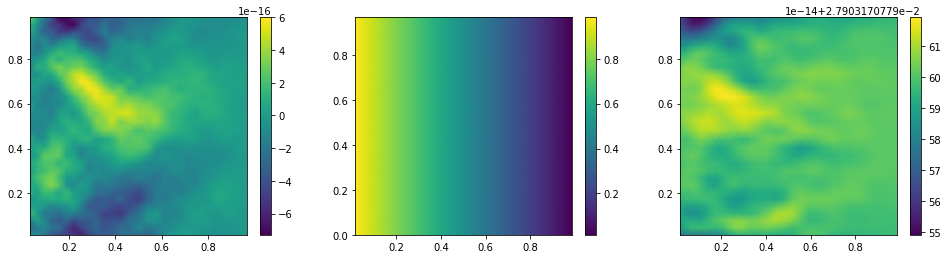

In [13]:
plt.figure(figsize=(5.5*3,4))
plt.subplot(1,3,1)
plt.pcolormesh(xu, yu, u, shading='gouraud')
plt.xlim(xu[0], xu[-1])
plt.ylim(yu[0], yu[-1])
plt.colorbar()

plt.subplot(1,3,2)
plt.pcolormesh(xv, yv, v, shading='gouraud')
plt.xlim(xv[0], xv[-1])
plt.ylim(yv[0], yv[-1])
plt.colorbar()

plt.subplot(1,3,3)
plt.pcolormesh(xp, yp, p, shading='gouraud')
plt.xlim(xp[0], xp[-1])
plt.ylim(yp[0], yp[-1])
plt.colorbar()

Comparison with theoretical results

(0, 1)

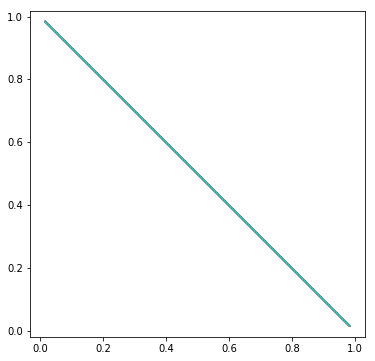

In [14]:
plt.figure(figsize=(6,6))
plt.plot(xv, v.T)
plt.axis('equal')
plt.ylim(0,1)
